In [22]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
# Import other libraries
import numpy as np
import zipfile
import io
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
# Import tensorflow
import logging
import tensorflow as tf
from tensorflow import keras as tfk
seed = 42
np.random.seed(seed)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tf.config.list_physical_devices('GPU')
print(tf.__version__)



class CNNModel:
    def __init__(self):
        self.model = self.create_model()
        # if self.loadmodel() is None:
        #     self.model = self.createModel()
        #     #self.model = None
        # else:
        #     self.model = None
        #     #self.model = self.loadmodel()
        # # self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def load_dataset(self):
        with zipfile.ZipFile('/content/drive/MyDrive/[2023-2024] AN2DL/Homework 1/public_data.zip', 'r') as zip_ref:
        # Extract the NumPy archive from the ZIP file
          with zip_ref.open('public_data.npz') as file:
            # Load the NumPy archive
            data = np.load(io.BytesIO(file.read()), allow_pickle=True)
        data_arr = data['data']
        data_arr = data_arr.astype('uint8')
        labels_arr = data['labels']
        return data_arr, labels_arr

    def preprocess_data(self, data_arr, labels_arr):
        normalized_data = (data_arr / 255).astype('float32')
        normalized_labels = labels_arr
        criteria = normalized_labels == 'unhealthy'
        normalized_labels[criteria] = 1
        criteria_0 = normalized_labels == 'healthy'
        normalized_labels[criteria_0] = 0
        normalized_labels = normalized_labels.astype('float32')
        return normalized_data, normalized_labels

    def create_data_split(self, normalized_data, normalized_labels):
        X_train, X_val, y_train, y_val = train_test_split(normalized_data, normalized_labels, random_state=seed,
                                                          test_size=0.2,
                                                          stratify=normalized_labels)

        # Print the shapes of the resulting datasets
        print("Training Data Shape:", X_train.shape)
        print("Training Label Shape:", y_train.shape)
        print("Validation Data Shape:", X_val.shape)
        print("Validation Label Shape:", y_val.shape)
        return X_train, X_val, y_train, y_val

    # def loadmodel():
    #     try:
    #         json_file = open('model.json', 'r')
    #         loaded_model_json = json_file.read()
    #         json_file.close()
    #         loaded_model = model_from_json(loaded_model_json)
    #         loaded_model.load_weights('model.h5')
    #         return loaded_model
    #     except FileNotFoundError:
    #         return None

    def create_model(self):
        model = Sequential()

        model.add(Conv2D(64, (3, 3), padding='same', input_shape=(96, 96, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        # 2nd CNN layer
        model.add(Conv2D(128, (5, 5), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        # 3rd CNN layer
        model.add(Conv2D(512, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        # 4th CNN layer
        model.add(Conv2D(512, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Flatten())

        # Fully connected 1st layer
        model.add(Dense(256))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.4))

        # Fully connected layer 2nd layer
        model.add(Dense(512))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        opt = tf.optimizers.Adam(lr=0.0001)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

    def train(self,  X_train, y_train, X_val, y_val, batch_size, epochs):
        early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                                                     restore_best_weights=True)

        # Train the model and save its history
        history = self.model.fit(
            x=X_train,
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val)
            # callbacks=[early_stopping]
        ).history

        return history

    def predict(self, X):

        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)  # Shape [BS]
        return out
    def cleanse_dataset(self, image_list, label_list):
      #Green Mask
      lower_green = (35, 50, 50)
      upper_green = (85, 255, 255)
      shrek = image_list[207]

      threshold = 100  # Adjust this threshold as needed

      indexes_with_green = []
      indexes_with_no_green = []
      for idx, image in enumerate(image_list):
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
        enough_green_mask = cv2.threshold(green_mask, threshold, 255, cv2.THRESH_BINARY)[1]
        if np.array_equal(image_list[idx], shrek):
          print('Ulazim u shreka ;)')
          indexes_with_no_green.append(idx)
        elif np.count_nonzero(enough_green_mask) > 13:
          # print('This image has enough green: ' + str(idx))
          #print(np.count_nonzero(enough_green_mask))
          indexes_with_green.append(idx)
        else:
          indexes_with_no_green.append(idx)
          #print('The image with not enough green is the following: ' + str(idx))
          #image_list = np.delete(image_list, idx)
          #label_list = np.delete(label_list, idx)
      print('The length of the images before the delete is : ' + str(len(image_list)))
      print('The length of the labels before the delete is : ' + str(len(label_list)))

      image_list = np.delete(image_list, indexes_with_no_green, axis=0)
      print('The length of the images after the delete is : ' + str(len(image_list)))
      label_list = np.delete(label_list, indexes_with_no_green)
      print('The length of the labels after the delete is : ' + str(len(label_list)))


      return image_list, label_list

2.14.0


In [23]:
test_model = CNNModel()
data_arr, labels_arr = test_model.load_dataset()
cleansed_data, cleansed_labels = test_model.cleanse_dataset(data_arr, labels_arr)
print(len(cleansed_data))
print(len(cleansed_labels))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 96, 96, 64)        1792      
                                                                 
 batch_normalization_42 (Ba  (None, 96, 96, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_42 (Activation)  (None, 96, 96, 64)        0         
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_42 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 48, 48, 128)      

In [ ]:
# from keras.engine.saving import model_from_json


# Import other libraries
# Import tensorflow
# Load the NPZ dataset



# test_model = CNNModel()
# data_arr, labels_arr = test_model.load_dataset()
# cleansed_data, cleansed_labels = test_model.cleanse_dataset(data_arr, labels_arr)
# print(len(cleansed_data))
# print(len(cleansed_labels))
prep_data, prep_labels = test_model.preprocess_data(cleansed_data, cleansed_labels)
X_train, X_val, y_train, y_val = test_model.create_data_split(prep_data, prep_labels)
history = test_model.train(X_train, y_train, X_val, y_val, batch_size=64, epochs=100)

Training Data Shape: (4003, 96, 96, 3)
Training Label Shape: (4003,)
Validation Data Shape: (1001, 96, 96, 3)
Validation Label Shape: (1001,)
Epoch 1/100
63/63 [==============================] - 14s 162ms/step - loss: 0.7575 - accuracy: 0.5981 - val_loss: 1.3109 - val_accuracy: 0.6194
Epoch 2/100
63/63 [==============================] - 8s 120ms/step - loss: 0.6547 - accuracy: 0.6667 - val_loss: 1.7789 - val_accuracy: 0.6194
Epoch 3/100
63/63 [==============================] - 7s 117ms/step - loss: 0.5924 - accuracy: 0.7085 - val_loss: 1.8844 - val_accuracy: 0.6194
Epoch 4/100
63/63 [==============================] - 8s 121ms/step - loss: 0.5729 - accuracy: 0.7235 - val_loss: 1.9101 - val_accuracy: 0.6194
Epoch 5/100
63/63 [==============================] - 7s 117ms/step - loss: 0.5619 - accuracy: 0.7372 - val_loss: 1.7165 - val_accuracy: 0.6194
Epoch 6/100
63/63 [==============================] - 7s 118ms/step - loss: 0.5339 - accuracy: 0.7389 - val_loss: 0.9438 - val_accuracy: 0.6254

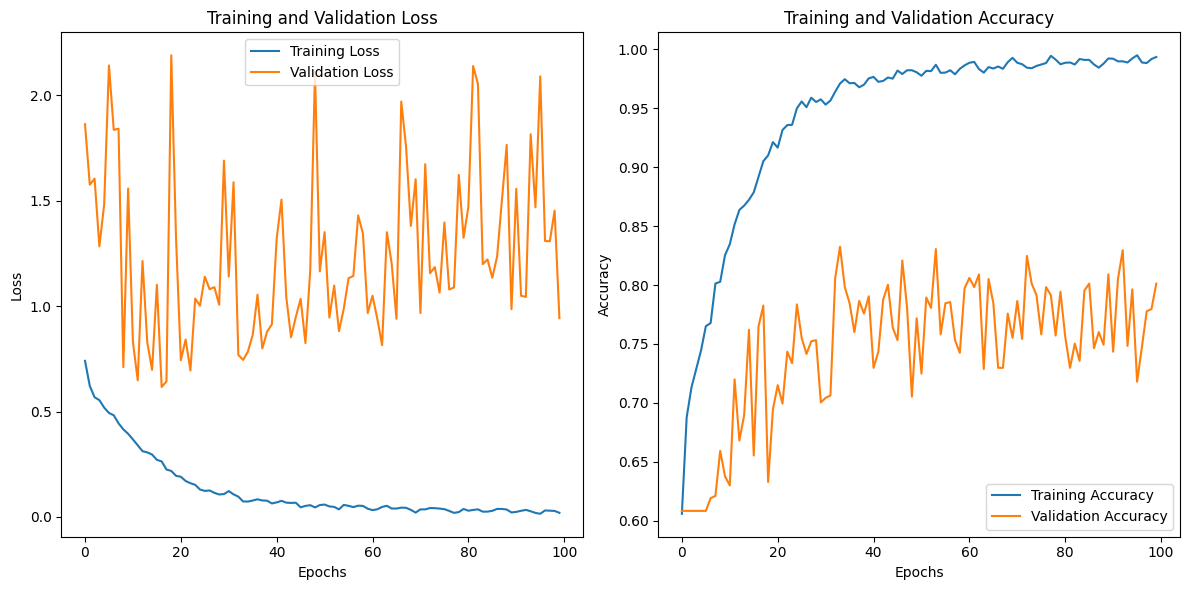

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

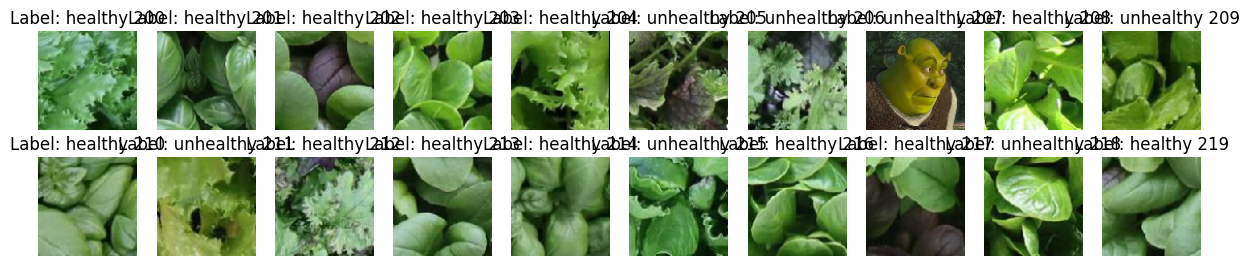

In [12]:
plt.figure(figsize=(15, 3))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(data_arr[i+ 200], cmap='gray')  # Assuming grayscale images, adjust the colormap as needed
    plt.title(f"Label: {labels_arr[i+ 200]} " + str(i+200))
    plt.axis('off')

plt.show()

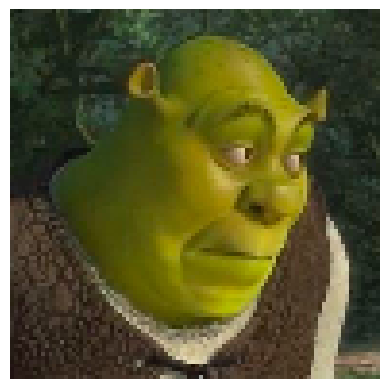

In [17]:
plt.imshow(data_arr[207])
plt.axis('off')  # Turn off axis labels
plt.show()

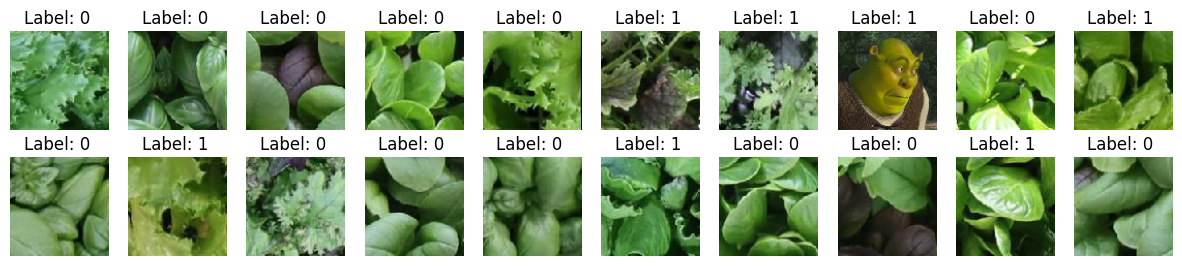

In [10]:
plt.figure(figsize=(15, 3))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(cleansed_data[i+200], cmap='gray')  # Assuming grayscale images, adjust the colormap as needed
    plt.title(f"Label: {cleansed_labels[i+200]} ")
    plt.axis('off')

plt.show()